In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from scipy import stats
import statsmodels.api as sm
import csv
import glob

In [2]:
df = pd.read_csv('CSVFiles/all_data_with_identities_50000.csv')

df = df.loc[:, ["comment_text", "split", "toxicity", "male", "female", "LGBTQ", "christian", "muslim", "other_religions", "black", "white"]]
df = df[df['split'] == 'test']

df['male'] = df['male'].apply(lambda x: np.round(x>=0.5))
df['female'] = df['female'].apply(lambda x: np.round(x>=0.5))
df['LGBTQ'] = df['LGBTQ'].apply(lambda x: np.round(x>=0.5))
df['christian'] = df['christian'].apply(lambda x: np.round(x>=0.5))
df['muslim'] = df['muslim'].apply(lambda x: np.round(x>=0.5))
df['other_religions'] = df['other_religions'].apply(lambda x: np.round(x>=0.5))
df['black'] = df['black'].apply(lambda x: np.round(x>=0.5))
df['white'] = df['white'].apply(lambda x: np.round(x>=0.5))

In [3]:
def loadTestAndValPreds(seed, pathPrefix):
    test_preds = []
    val_preds = []
    test_path = pathPrefix+'test_seed-'+ str(seed) + '_epoch-best_pred.csv'
    #val_path = pathPrefix+'val_seed-'+ str(seed) + '_epoch-best_pred.csv'
    test_preds = pd.read_csv(test_path, header=None)
    val_preds = pd.read_csv(val_path, header=None)

    test_preds = pd.DataFrame({'test predictions': np.array(test_preds.values.tolist()).flatten()}, index = df.index)
    val_preds = pd.DataFrame({'val predictions': np.array(val_preds.values.tolist()).flatten()}, index = df.index)
    
    return test_preds, val_preds

In [4]:
def CheckAccuracy(predictions, labels):
        acc = 0.0
        for i in range(len(predictions)):
            if (predictions[i] == labels[i]):
                acc += 1
        return acc/len(predictions)

def F1AndAcc(df):
    f1_scores = []
    accuracies = []
    demographics = []
    
    for col in df.columns[4:]:
        tempdf = df[(df[col] == 1)]        
        
        labels = np.array(tempdf['toxicity'].values.tolist())
        predictions = np.array(tempdf['test predictions'].values.tolist())
        
        f1_scores.append(f1_score(labels, predictions, zero_division=1))
        accuracies.append(CheckAccuracy(labels, predictions))   
    return np.array(f1_scores), np.array(accuracies)


def pRule(df):
    pRules = []
    
    for col in df.columns[4:]:
        
        tempdfz1 = df[(df[col] == 1)]      
        tempdfz0 = df[(df[col] == 0)]
        
        labelsz1 = np.array(tempdfz1['toxicity'].values.tolist())
        predictionsz1 = np.array(tempdfz1['test predictions'].values.tolist())
        
        labelsz0 = np.array(tempdfz0['toxicity'].values.tolist())
        predictionsz0 = np.array(tempdfz0['test predictions'].values.tolist())
        
        with np.errstate(divide='ignore'):
            
            z1Ut1 = np.sum(predictionsz1)/len(df)
            pz1 = len(predictionsz1)/len(df)
            
            z0Ut1 = np.sum(predictionsz0)/len(df)
            pz0 = len(predictionsz0)/len(df)
            
            pscore0 = (z1Ut1/pz1) / (z0Ut1/pz0)
            pscore1 = (z0Ut1/pz0) / (z1Ut1/pz1)
        
        if np.isnan(pscore0) or np.isnan(pscore1):
            finalpscore = 0
        else:
            finalpscore = min(pscore0, pscore1)
        
        pRules.append(finalpscore)
    return pRules


def pRuleOwn(df):
    pRules = []
    
    for col in df.columns[4:]:
        tempdfz1 = df[(df[col] == 1)]      
        tempdfz0 = df[(df[col] == 0)]
        
        labelsz1 = np.array(tempdfz1['toxicity'].values.tolist())
        predictionsz1 = np.array(tempdfz1['test predictions'].values.tolist())
        
        labelsz0 = np.array(tempdfz0['toxicity'].values.tolist())
        predictionsz0 = np.array(tempdfz0['test predictions'].values.tolist())
        
        with np.errstate(divide='ignore'):
            pscore0 = (np.sum(predictionsz1)/np.sum(labelsz1))/(np.sum(predictionsz0)/np.sum(labelsz0))
            pscore1 = (np.sum(predictionsz0)/np.sum(labelsz0))/(np.sum(predictionsz1)/np.sum(labelsz1))
        
        if np.isnan(pscore0) or np.isnan(pscore1):
            finalpscore = 0
        else:
            finalpscore = min(pscore0, pscore1)
        
        pRules.append(finalpscore)
    return pRules

def MinMaxFairness(scores):
    return np.max(scores)-np.min(scores)

def VarianceFairness(scores):
    return np.var(scores)


In [12]:
# Checking all privacy models
epsilons = np.array([1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

orderCSV = []
paths1 = []
for csv in glob.glob('finalOwnWilds/logs/50000Every1Run1/Test/*'):
    orderCSV.append(csv[70:73])
    paths1.append(csv)
paths1 = np.array(paths1)[np.argsort(np.array(orderCSV).astype(int))]

orderCSV = []
paths2 = []
for csv in glob.glob('finalOwnWilds/logs/50000Every1Run2/Test/*'):
    orderCSV.append(csv[70:73])
    paths2.append(csv)
paths2 = np.array(paths2)[np.argsort(np.array(orderCSV).astype(int))]

orderCSV = []
paths3 = []
for csv in glob.glob('finalOwnWilds/logs/50000Every1Run3/Test/*'):
    orderCSV.append(csv[70:73])
    paths3.append(csv)
paths3 = np.array(paths3)[np.argsort(np.array(orderCSV).astype(int))]

orderCSV = []
paths4 = []
for csv in glob.glob('finalOwnWilds/logs/50000Every1Run4/Test/*'):
    orderCSV.append(csv[70:73])
    paths4.append(csv)
paths4 = np.array(paths4)[np.argsort(np.array(orderCSV).astype(int))]


orderCSV = []
paths5 = []
for csv in glob.glob('finalOwnWilds/logs/50000Every1Run5/Test/*'):
    orderCSV.append(csv[70:73])
    paths5.append(csv)
paths5 = np.array(paths5)[np.argsort(np.array(orderCSV).astype(int))]

#AllPaths = [paths1, paths2, paths3, paths4, paths5]

AllPaths = [paths1, paths2, paths3, paths5]

allvarF1 = []
allminMaxF1 = []
allpRuleOwnMeanArr = []
allpRuleOwnMinArr = []
allpRuleMeanArr = []
allpRuleMinArr = []
allaccuracy = []


for i, run in enumerate(AllPaths):
    
    varF1 = []
    minMaxF1 = []
    pRuleOwnMeanArr = []
    pRuleOwnMinArr = []
    pRuleMeanArr = []
    pRuleMinArr = []
    accuracy = []
    
    for csvFile in run:
        test_preds = pd.read_csv(csvFile, header=None) 
        test_preds = pd.DataFrame({'test predictions': np.array(test_preds.values.tolist()).flatten()}, index = df.index)
        temp_df = pd.concat([test_preds, df], axis=1)
        
        
        f1_scores, accuracies = F1AndAcc(temp_df)
        
        own = pRuleOwn(temp_df)       
        
        pRuleOwnMinArr.append(np.min(own))
        pRuleOwnMeanArr.append(np.mean(own))
        
        official = pRule(temp_df)
        pRuleMinArr.append(np.min(official))
        pRuleMeanArr.append(np.mean(official))

        #F1 Variance
        varF1.append(VarianceFairness(f1_scores))

        #F1 Min Max
        minMaxF1.append(MinMaxFairness(f1_scores))
        
        labels = np.array(temp_df['toxicity'].values.tolist())
        preds = np.array(temp_df['test predictions'].values.tolist())
        accuracy.append(CheckAccuracy(preds,labels))
        
    allvarF1.append(np.array(varF1))
    allminMaxF1.append(np.array(minMaxF1))
    allpRuleOwnMeanArr.append(np.array(pRuleOwnMeanArr))
    allpRuleOwnMinArr.append(np.array(pRuleOwnMinArr))
    allpRuleMeanArr.append(np.array(pRuleMeanArr))
    allpRuleMinArr.append(np.array(pRuleMinArr))
    allaccuracy.append(np.array(accuracy))
    
allvarF1 = np.array(allvarF1).mean(axis=0)
allminMaxF1 = np.array(allminMaxF1).mean(axis=0)
allpRuleOwnMeanArr = np.array(allpRuleOwnMeanArr).mean(axis=0)
allpRuleOwnMinArr = np.array(allpRuleOwnMinArr).mean(axis=0)
allpRuleMeanArr = np.array(allpRuleMeanArr).mean(axis=0)
allpRuleMinArr = np.array(allpRuleMinArr).mean(axis=0)
allaccuracy = np.array(allaccuracy).mean(axis=0)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1.531
Date:                Sun, 06 Jun 2021   Prob (F-statistic):              0.226
Time:                        15:27:24   Log-Likelihood:                 67.960
No. Observations:                  30   AIC:                            -131.9
Df Residuals:                      28   BIC:                            -129.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7310      0.010     75.089      0.0

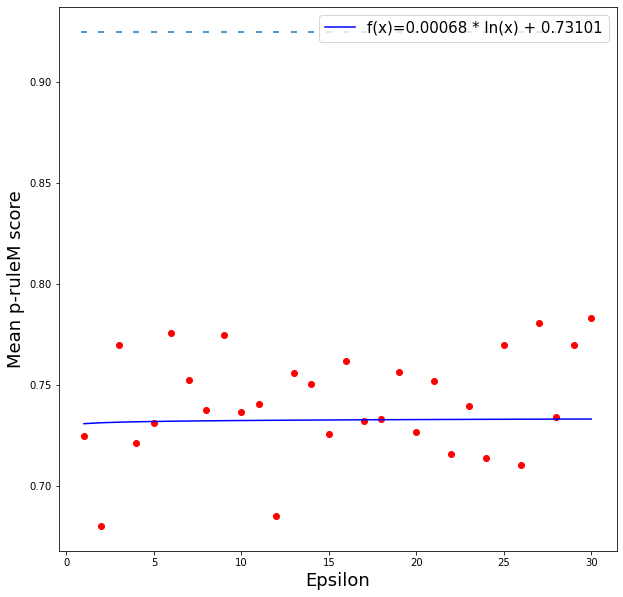

In [34]:
# PLOT OWN P-RULE MEAN

m, b = np.polyfit(epsilons, allpRuleOwnMeanArr, 1)

X2 = sm.add_constant(epsilons)
est = sm.OLS(allpRuleOwnMeanArr, X2)
est2 = est.fit()
print(est2.summary())

print(stats.pearsonr(epsilons, allpRuleOwnMeanArr))

plt.figure(figsize=(10,10))
plt.scatter(epsilons, allpRuleOwnMeanArr, color='r')
plt.scatter(epsilons, np.multiply(len(epsilons)*[1.0], 0.9250), marker = '_')
#plt.scatter(epsilons, epsValues)
plt.plot(epsilons, m*np.log(epsilons) + b, color='b', label='f(x)='+"{:.5f}".format(m)+' * ln(x) + '+ "{:.5f}".format(b))
#plt.plot(epsilons, 0*epsilons + pRuleOwnMean)
#plt.title("", fontsize=18)
plt.xlabel("Epsilon", fontsize=18)
plt.ylabel("Mean p-ruleM score", fontsize=18)
plt.legend(loc="upper right", fontsize=15)
plt.savefig('5OwnMeanWilds1to30eps.png', bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     3.073
Date:                Sun, 06 Jun 2021   Prob (F-statistic):             0.0906
Time:                        15:27:24   Log-Likelihood:                 64.625
No. Observations:                  30   AIC:                            -125.3
Df Residuals:                      28   BIC:                            -122.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5670      0.017     34.045      0.0

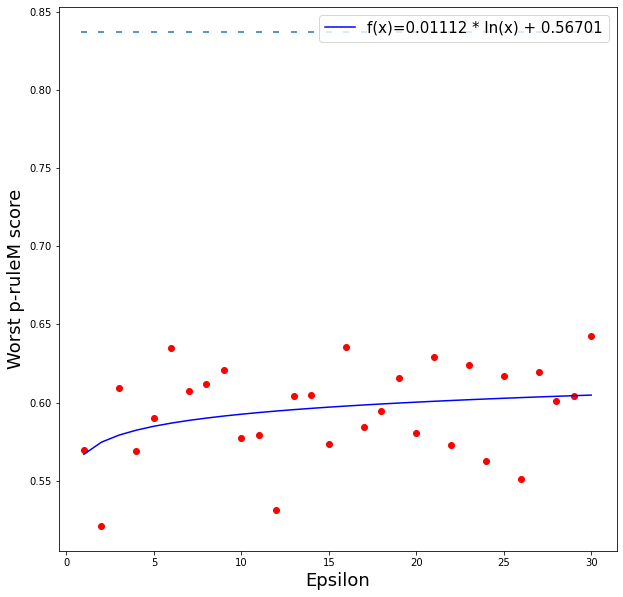

In [35]:
# PLOT OWN P-RULE MIN
m, b = np.polyfit(np.log(epsilons), allpRuleOwnMinArr, 1)

X2 = sm.add_constant(np.log(epsilons))
est = sm.OLS(allpRuleOwnMinArr, X2)
est2 = est.fit()
print(est2.summary())

plt.figure(figsize=(10,10))
plt.scatter(epsilons, allpRuleOwnMinArr, color='r')
plt.scatter(epsilons, np.multiply(len(epsilons)*[1.0], 0.8371), marker = '_')
plt.plot(epsilons, m*np.log(epsilons) + b, color='b', label='f(x)='+"{:.5f}".format(m)+' * ln(x) + '+ "{:.5f}".format(b))
#plt.plot(epsilons, 0*epsilons + pRuleOwnMin)
#plt.title("", fontsize=18)
plt.xlabel("Epsilon", fontsize=18)
plt.ylabel("Worst p-ruleM score", fontsize=18)
plt.legend(loc="upper right", fontsize=15)
plt.savefig('5OwnMinWilds1to30eps.png', bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.030
Method:                 Least Squares   F-statistic:                    0.1642
Date:                Sun, 06 Jun 2021   Prob (F-statistic):              0.688
Time:                        15:27:24   Log-Likelihood:                 61.479
No. Observations:                  30   AIC:                            -119.0
Df Residuals:                      28   BIC:                            -116.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6741      0.018     36.443      0.0

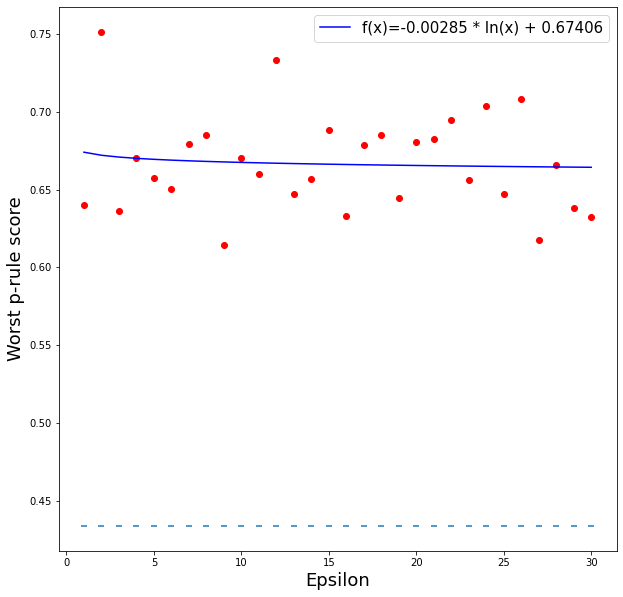

In [36]:
# PLOT OFFICIAL P-RULE MIN

m, b = np.polyfit(np.log(epsilons), allpRuleMinArr, 1)

X2 = sm.add_constant(np.log(epsilons))
est = sm.OLS(allpRuleMinArr, X2)
est2 = est.fit()
print(est2.summary())

plt.figure(figsize=(10,10))
plt.scatter(epsilons, allpRuleMinArr, color='r')
plt.scatter(epsilons, np.multiply(len(epsilons)*[1.0], 0.4336), marker = '_')
plt.plot(epsilons, m*np.log(epsilons) + b, color='b', label='f(x)='+"{:.5f}".format(m)+' * ln(x) + '+ "{:.5f}".format(b))
#plt.plot(epsilons, 0*epsilons + pRuleMin)
#plt.title("", fontsize=18)
plt.xlabel("Epsilon", fontsize=18)
plt.ylabel("Worst p-rule score", fontsize=18)
plt.legend(loc="upper right", fontsize=15)
plt.savefig('5OfficialMinWilds1to30eps.png', bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.7744
Date:                Sun, 06 Jun 2021   Prob (F-statistic):              0.386
Time:                        15:27:25   Log-Likelihood:                 67.978
No. Observations:                  30   AIC:                            -132.0
Df Residuals:                      28   BIC:                            -129.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8085      0.015     54.283      0.0

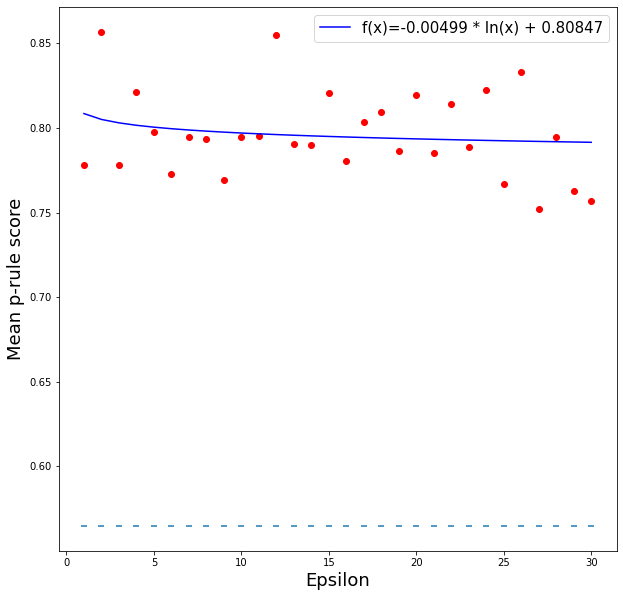

In [37]:
# PLOT OFFICIAL P-RULE Mean

m, b = np.polyfit(np.log(epsilons), allpRuleMeanArr, 1)

X2 = sm.add_constant(np.log(epsilons))
est = sm.OLS(allpRuleMeanArr, X2)
est2 = est.fit()
print(est2.summary())

plt.figure(figsize=(10,10))
plt.scatter(epsilons, allpRuleMeanArr, color='r')
plt.scatter(epsilons, np.multiply(len(epsilons)*[1.0], 0.5647), marker = '_')
plt.plot(epsilons, m*np.log(epsilons) + b, color='b', label='f(x)='+"{:.5f}".format(m)+' * ln(x) + '+ "{:.5f}".format(b))
#plt.plot(epsilons, 0*epsilons + pRuleMean)
#plt.title("", fontsize=18)
plt.xlabel("Epsilon", fontsize=18)
plt.ylabel("Mean p-rule score", fontsize=18)
plt.legend(loc="upper right", fontsize=15)
plt.savefig('5OfficialMeanWilds1to30eps.png', bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     5.514
Date:                Sun, 06 Jun 2021   Prob (F-statistic):             0.0262
Time:                        15:27:25   Log-Likelihood:                 195.16
No. Observations:                  30   AIC:                            -386.3
Df Residuals:                      28   BIC:                            -383.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.000     11.704      0.0

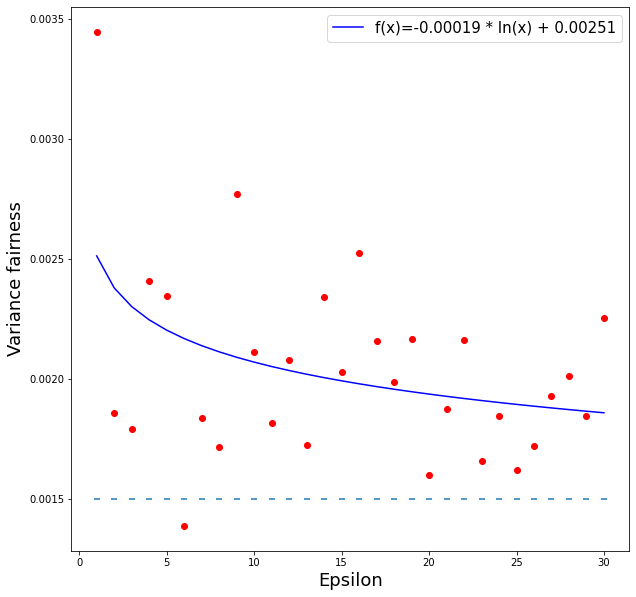

In [38]:
m, b = np.polyfit(np.log(epsilons), allvarF1, 1)

X2 = sm.add_constant(np.log(epsilons))
est = sm.OLS(allvarF1, X2)
est2 = est.fit()
print(est2.summary())

plt.figure(figsize=(10,10))
plt.scatter(epsilons, allvarF1, color='r')
plt.scatter(epsilons, np.multiply(len(epsilons)*[1.0], 0.0015), marker = '_')
plt.plot(epsilons, m*np.log(epsilons) + b, color='b', label='f(x)='+"{:.5f}".format(m)+' * ln(x) + '+ "{:.5f}".format(b))
#plt.title("Fairness", fontsize=18)
plt.xlabel("Epsilon", fontsize=18)
plt.ylabel("Variance fairness", fontsize=18)
plt.legend(loc="upper right", fontsize=15)
plt.savefig('5varf1Wilds1to30eps.png', bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     5.514
Date:                Sun, 06 Jun 2021   Prob (F-statistic):             0.0262
Time:                        15:27:25   Log-Likelihood:                 195.16
No. Observations:                  30   AIC:                            -386.3
Df Residuals:                      28   BIC:                            -383.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.000     11.704      0.0

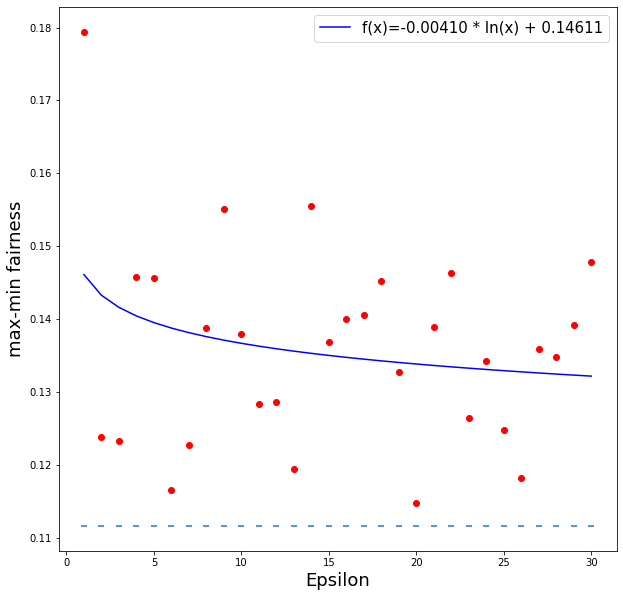

In [39]:
X2 = sm.add_constant(np.log(epsilons))
est = sm.OLS(allvarF1, X2)
est2 = est.fit()
print(est2.summary())

m, b = np.polyfit(np.log(epsilons), allminMaxF1, 1)
plt.figure(figsize=(10,10))
plt.scatter(epsilons, allminMaxF1, color='r')
plt.scatter(epsilons, np.multiply(len(epsilons)*[1.0], 0.1116), marker = '_')
plt.plot(epsilons, m*np.log(epsilons) + b, color='b', label='f(x)='+"{:.5f}".format(m)+' * ln(x) + '+ "{:.5f}".format(b))
plt.xlabel("Epsilon", fontsize=18)
plt.ylabel("max-min fairness", fontsize=18)
plt.legend(loc="upper right", fontsize=15)
plt.savefig('5minmaxf1Wilds1to30eps.png', bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     4.898
Date:                Sun, 06 Jun 2021   Prob (F-statistic):             0.0352
Time:                        15:27:26   Log-Likelihood:                 91.922
No. Observations:                  30   AIC:                            -179.8
Df Residuals:                      28   BIC:                            -177.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6615      0.007     98.670      0.0

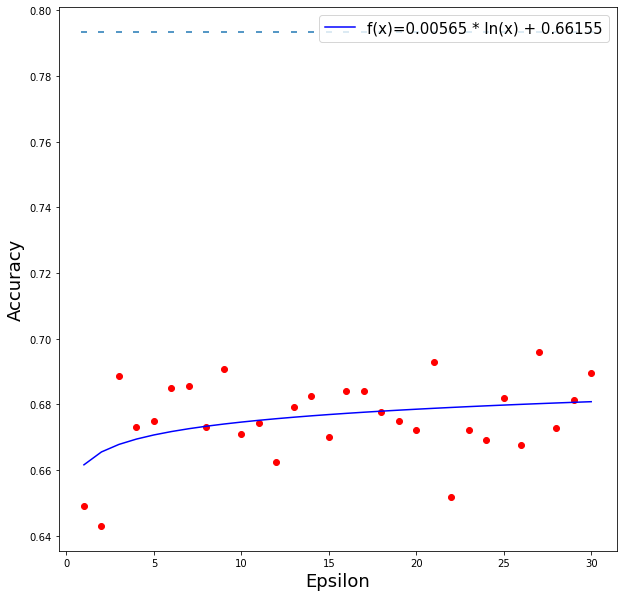

In [40]:
X2 = sm.add_constant(np.log(epsilons))
est = sm.OLS(allaccuracy, X2)
est2 = est.fit()
print(est2.summary())

m, b = np.polyfit(np.log(epsilons), allaccuracy, 1)

plt.figure(figsize=(10,10))
plt.scatter(epsilons, allaccuracy, color='r')
plt.scatter(epsilons, np.multiply(len(epsilons)*[1.0], 0.7934), marker = '_')
plt.plot(epsilons, m*np.log(epsilons) + b, color='b', label='f(x)='+"{:.5f}".format(m)+' * ln(x) + '+ "{:.5f}".format(b))
plt.xlabel("Epsilon", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)
plt.legend(loc="upper right", fontsize=15)
plt.savefig('5accuracyWilds1to30eps.png', bbox_inches='tight')
plt.show()

In [41]:
# Checking no privacy model
varF1 = []
minMaxF1 = []
pRuleOwnMeanArr = []
pRuleOwnMinArr = []
pRuleMeanArr = []
pRuleMinArr = []
accuracy = []
for i in range(1,11):
    test_preds, val_preds = loadTestAndValPreds(i, 'finalOwnWilds/logs/50000noDP/civilcomments_split-')
    temp_df = pd.concat([test_preds, df], axis=1)
    f1_scores, accuracies = F1AndAcc(temp_df)

    own = pRuleOwn(temp_df)       
    pRuleOwnMinArr.append(np.min(own))
    pRuleOwnMeanArr.append(np.mean(own))

    official = pRule(temp_df)
    pRuleMinArr.append(np.min(official))
    pRuleMeanArr.append(np.mean(official))

    #F1 Variance
    varF1.append(VarianceFairness(f1_scores))

    #F1 Min Max
    minMaxF1.append(MinMaxFairness(f1_scores))

    labels = np.array(temp_df['toxicity'].values.tolist())
    preds = np.array(temp_df['test predictions'].values.tolist())
    accuracy.append(CheckAccuracy(preds,labels))

NameError: name 'val_path' is not defined

In [ ]:
print(f'varF1:\t\t {np.mean(varF1):.4f}')
print(f'minMaxF1:\t {np.mean(minMaxF1):.4f}')
print(f'pRuleOwnMeanArr: {np.mean(pRuleOwnMeanArr):.4f}')
print(f'pRuleOwnMinArr:\t {np.mean(pRuleOwnMinArr):.4f}')
print(f'pRuleMeanArr:\t {np.mean(pRuleMeanArr):.4f}')
print(f'pRuleMinArr:\t {np.mean(pRuleMinArr):.4f}')
print(f'Avg accuracy:\t {np.mean(accuracy):.4f}')